# EE798 HW3

In [152]:
from scipy.linalg import toeplitz, dft, inv, eigvals, eig, kron, eigh
from scipy.signal import convolve2d, convolve
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2
import matplotlib.pyplot as plt
from skimage.data import camera 


## Q1 a

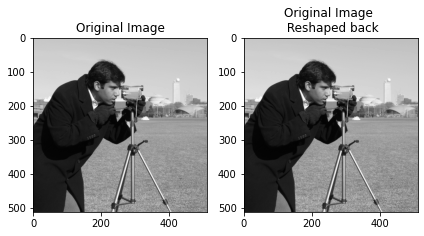

In [153]:
I = camera()
I_flatten = I.flatten(order="F")
I_back = np.reshape(I,(I.shape))
plt.subplot(1,2,1)
plt.imshow((I),cmap="gray")
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow((I_back),cmap="gray")
plt.title("Original Image \n Reshaped back")
plt.tight_layout()


### The vectors stacked in matrix H are flattened version of the convolved vectors of basis pixels. Since flattened basis vectors are lexicographically ordered, we observed shifted versions of block of the output vectors in the matrix, hence in a Toeplitz form. 

### This matrix may be too huge to store for a huge image size.

# Q1 b

### Given that H is of size $(P1,P2)$ and image of size $(N1,N2)$, FFT points of $$(N1+P1-1,N2+P2-1) = (L_1,L_2)$$ should be used to have [linear convolution](#linear_conv_cell).

### If FFT points $(N_1,N_2)$ are higher than the image sizes, the images are padded zeros until they have FFT points size, as in the case of linear convolution calculation. On the other hand, if we were to use fewer points FFT, then the images are rolled onto themselves in the following manner: $$\hat{x}(m,n) = \sum\limits_{i=-\infty}^{\infty}\sum\limits_{j=-\infty}^{\infty}x(m+N1i,n+N2j)$$ 

In [154]:
def cconv2(x:np.ndarray, y:np.ndarray,N1:int,N2:int):
    sizes = (N1,N2)
    return ifft2(np.multiply(fft2(x,sizes),fft2(y,sizes)))
    

### Tests

In [155]:
for _ in range(200):
    N1 = np.random.randint(1,5)
    N2 = np.random.randint(1,10)
    N3 = np.random.randint(1,20)
    x = np.random.randint(0,100,(N1,N1))
    y = np.random.randint(0,100,(N2,N3))
    cconv_size_1 = N1+N2-1
    cconv_size_2 = N1+N3-1
    res = convolve2d(x,y,mode="full")
    res2 = np.round(cconv2(x,y,cconv_size_1,cconv_size_2))
    assert np.sum(np.isclose(res,res2)) == res.size
print("All tests are success!")

All tests are success!


# Q1 c

In [156]:
def cconvmtx2(h:np.ndarray, image_shape, N1, N2):
    L1,L2 = image_shape
    H = np.empty((N1*N2,0))
    image_size = L1*L2
    for i in range(image_size):
        row = np.mod(i,L1)
        col = i//L1
        basis_vec = np.zeros((L1,L2))
        basis_vec[row,col] = 1
        basis_vec_output = cconv2(h,basis_vec,N1,N2)
        transformed_basis_vec = basis_vec_output.flatten(order="F")
        H = np.column_stack((H, transformed_basis_vec))
    return H 

## Verification

In [157]:
for trial in range(100):
    
    P1 =  np.random.randint(1,3)
    P2 =  np.random.randint(1,3)
    L1 = np.random.randint(P1,10)
    L2 = np.random.randint(P2,10)
    N1 = np.random.randint(L1,20)
    N2 = np.random.randint(L2,20)

    
    h = np.random.randint(1,5,(P1,P2))
    test_image = np.random.randint(1,100,(L1,L2))
    res = cconv2(h,test_image, N1, N2)
    H = cconvmtx2(h, test_image.shape, N1, N2)
    res2 = np.reshape(H.dot(test_image.flatten(order="F")),(N1,N2),order="F")
    assert np.sum(np.isclose(res,res2)) == res.size
    
print("All tests are success!")

All tests are success!


<a id='linear_conv_cell'></a>
## A linear convolution example $\downarrow$

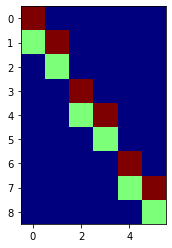

In [158]:
P1 =  np.random.randint(1,6)
P2 =  np.random.randint(1,6)
L1 = np.random.randint(P1,10)
L2 = np.random.randint(P2,10)
N1 = L1 + P1 - 1
N2 = L2 + P2 - 1


h = np.random.randint(1,5,(P1,P2))
test_image = np.random.randint(1,100,(L1,L2))
res = cconv2(h,test_image, N1, N2)
H = cconvmtx2(h, test_image.shape, N1, N2)
plt.imshow(np.real(H))

# Q1 d

In [159]:
def dftmtx2(N1:int, N2:int):
    F = np.empty((N1*N2,0))
    for i in range(N1*N2):
        row = np.mod(i,N1)
        col = i//N1
        basis_vec = np.zeros((N1,N2))
        basis_vec[row,col] = 1
        basis_vec_output = fft2(basis_vec,(N1,N2))
        transformed_basis_vec = basis_vec_output.flatten(order="F")
        F = np.column_stack((F, transformed_basis_vec))
    return F

## Verification 

### $(2DFFT(I))_{flat} == FI_{flat}$ ###

In [160]:
for trial in range(100):
    
    N1 = np.random.randint(1,20)
    N2 = np.random.randint(1,20)

    
    test_image = np.random.randint(1,100,(N1,N2))
    res = fft2(test_image, (N1, N2))
    F = dftmtx2(N1, N2)
    res2 = np.reshape(F.dot(test_image.flatten(order="F")),(N1,N2),order="F")
    assert np.sum(np.isclose(res,res2)) == res.size
    
print("All tests are success!")

All tests are success!


### Since FFT matrix entries are symmetrical with respect to variables $n1$, $k1$ and $n2$, $k2$ the matrix is symmetric, _i.e._ $ F = F^T$. Inverse FFT matrix $F^{-1}$ have just conjugated entries scaled with $\frac{1}{N_1N_2}$ of F. Hence $F^{-1} = \frac{F^H}{N_1N_2}$ 

Shape of H:  (9, 9)
Shape of Image:  (3, 3)
Shape of H:  (36, 36)
Shape of Image:  (6, 6)
Shape of H:  (81, 81)
Shape of Image:  (9, 9)
Shape of H:  (64, 64)
Shape of Image:  (8, 8)
Shape of H:  (36, 36)
Shape of Image:  (6, 6)
Shape of H:  (16, 16)
Shape of Image:  (4, 4)
Shape of H:  (36, 36)
Shape of Image:  (6, 6)
Shape of H:  (81, 81)
Shape of Image:  (9, 9)
Shape of H:  (36, 36)
Shape of Image:  (6, 6)
Shape of H:  (36, 36)
Shape of Image:  (6, 6)
Shape of H:  (1, 1)
Shape of Image:  (1, 1)
Shape of H:  (1, 1)
Shape of Image:  (1, 1)
Shape of H:  (16, 16)
Shape of Image:  (4, 4)
Shape of H:  (25, 25)
Shape of Image:  (5, 5)
Shape of H:  (16, 16)
Shape of Image:  (4, 4)
Shape of H:  (64, 64)
Shape of Image:  (8, 8)
Shape of H:  (9, 9)
Shape of Image:  (3, 3)
Shape of H:  (49, 49)
Shape of Image:  (7, 7)
Shape of H:  (1, 1)
Shape of Image:  (1, 1)
Shape of H:  (9, 9)
Shape of Image:  (3, 3)
Shape of H:  (1, 1)
Shape of Image:  (1, 1)
Shape of H:  (25, 25)
Shape of Image:  (5, 5)
Sh

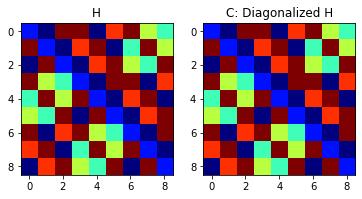

In [162]:
for _ in range(100):
    
    N = np.random.randint(1,10,(1,1)).item()
    P = N
    h = np.random.randint(1,10,(P,P))
    Image = np.random.randint(1,10,(N,N))
    H = cconvmtx2(h,Image.shape,N,N)
    print("Shape of H: ", H.shape)
    print("Shape of Image: ", Image.shape)

    F = dftmtx2(N,N)
    plt.subplot(1,2,1)
    plt.imshow(np.real(H))
    plt.title("H")
    C = F*H*F.conjugate().T
    plt.subplot(1,2,2)
    plt.imshow(np.real(C))
    plt.title("C: Diagonalized H")
    
    assert np.sum(np.isclose(C,H)) == H.size
    
